In [17]:
%matplotlib inline
%matplotlib inline
import numpy as np
import scipy
from scipy import optimize
from scipy import integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# The Human Eye

The human eye has 3 different types of photoreceptor cells:
1. [Rod cells](https://en.wikipedia.org/wiki/Rod_cell), which function to detect brightness
2. [Cone cells](https://en.wikipedia.org/wiki/Cone_cell), which function to detect color
3. [Photosensitive Retinal Ganglion cells (pRGC)](https://en.wikipedia.org/wiki/Intrinsically_photosensitive_retinal_ganglion_cells), which are thought to influence the circadian rythm and a few other things.

Rod cells and pRGCs are thought to have little influence on color sensing of the human eye so we will not cover them here. Links above if you want to investigate further (obligatory Wikipedia black hole warning!!).

## Cone cells

The human eye has 3 different types of cones that have peaks of sensitivity in:
1. Short (S): 420 nm - 440 nm
2. Middle (M): 530 nm - 540 nm
3. Long (L): 560 nm - 580 nm

The full spectrums for the average human cone cells are shown below.

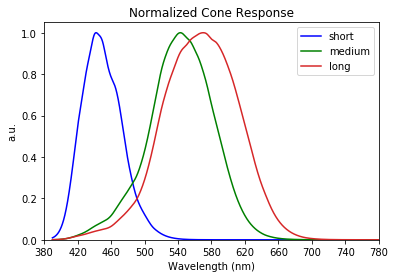

In [19]:
df = pd.read_csv('2deg_cone_response.csv',names=['wavelength','long','medium','short']);
# s_curve = df['short'];
lam2 = df['wavelength'];
s_curve = df['short'];
s_curve[np.isnan(s_curve)] = 0;
m_curve = df['medium'];
m_curve[np.isnan(m_curve)] = 0;
l_curve = df['long'];
l_curve[np.isnan(l_curve)] = 0;

# plt.figure(figsize=(8,8))
plt.plot(lam,s_curve,label='short',color='blue');
plt.plot(lam,m_curve,label='medium',color='green');
plt.plot(lam,l_curve,label='long',color='tab:red');
plt.title('Normalized Cone Response')
plt.xlabel('Wavelength (nm)');
plt.xlim([380, 780]); plt.xticks(np.arange(380,820,40));
plt.ylim([0,1.05]);
plt.ylabel('a.u.');
plt.legend()

Commonly we talk about human vision being seen in red-green-blue (RGB) as correlated to the peaks of the cones responses; however, tying these to exact colors is very misleading as you can see that the "green" cone (M) can also see "red" wavelengths. Thus, researchers often prefer to refer to human vision as bing SML for the different cone types.
  

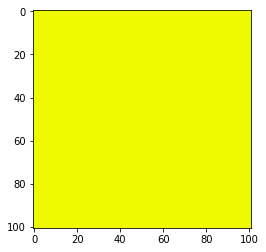

In [59]:
def wave2rgb(wv,lam,long,med,short):
    r = np.interp(wv,lam,long);
    g = np.interp(wv,lam,med);
    b = np.interp(wv,lam,short);
    return [r,g,b]

xx = wave2rgb(550,lam,l_curve,m_curve,s_curve)
tt = np.ones((101,101,3))*xx;
plt.imshow(tt)

  
## [Luminous Flux & Human Eye Sensitivity](https://en.wikipedia.org/wiki/Luminous_flux)

Before we start to talk about color in depth though, let's treat the eye as a single entity to understand its sensitivity to the electromagnetic spectrum as a whole. The human eye is sensitive to a narrow band of wavelengths of the electromagnetic spectrum as can be seen here.

<a href="https://www.beka-schreder.co.za/wp-content/uploads/2016/04/Visible-spectrum.jpg">
<img width="600" src="visible-spectrum-of-light.jpg"></a>

Here the visible light spectrum is defined from 380 nm to 780 nm. The natural question then is, "Why this range?" This is traditionally defined by the _luminous flux_ or _luminous power_ which is the **perceived** power of light by the human eye. Note that this is not the actual power of light, but is actually the amount of light you or I can perceive.

Some very smart people measured the eye's response to light along time ago and came up with the standard curves for eye sensitivity.

**Nerd Note:** _We are showing here the 2-degree photopic response of the eye. This means how the eye behaves in standard lighting conditions (i.e. not low light) with light entering a 2-degree window of the pupil. There are other sensitivity curves for differnet lighting conditions and different angles of capture that we will not cover here._

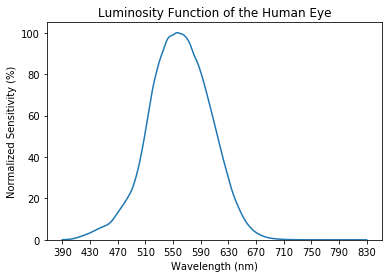

In [8]:
df = pd.read_csv('2deg_luminous_function.csv',names=['wave','amp'])
lam      = df['wave'];
lum_func = df['amp'];

plt.plot(lam,lum_func*100);
plt.xlabel('Wavelength (nm)');
plt.ylabel('Normalized Sensitivity (%)');
plt.title('Luminosity Function of the Human Eye');
plt.xticks(np.arange(np.amin(lam),np.amax(lam)+40,step=40));
plt.ylim([0, 105]);

[[390.  394.4 398.8 ... 821.2 825.6 830. ]
 [390.  394.4 398.8 ... 821.2 825.6 830. ]
 [390.  394.4 398.8 ... 821.2 825.6 830. ]
 ...
 [390.  394.4 398.8 ... 821.2 825.6 830. ]
 [390.  394.4 398.8 ... 821.2 825.6 830. ]
 [390.  394.4 398.8 ... 821.2 825.6 830. ]]
[[0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 ...
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]]


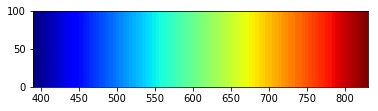

In [16]:
xx = np.linspace(np.amin(lam),np.amax(lam),101);
yy = np.linspace(0,1,101);
xv, yv = np.meshgrid(xx,yy);
print(xv)
xv = (xv - np.amin(xv))/(np.amax(xv) - np.amin(xv))
print(xv)
plt.imshow(xv,cmap='jet',extent=[np.amin(lam),np.amax(lam),0,100])

Here you can see that the eye's sensitivity peaks at around 550 nm and decreases significantly from there, approaching 0 outside of the 390 nm and 710 nm range. This means two things for us:
1. That a green light (~550 nm) at a fixed power level will look brighter to us than a red light (~700 nm) or blue light (~450 nm) at that same power level
2. We can effectively bound the spectrum we are concerned about to encompass this curve, giving us the approximate 380 - 780 nm bounds.


# The Light Bulb

One way to understand this concept of percieved light is to look at how we measure the efficiency of standard light bulbs. Incandescent bulbs are often quoted as having extremely low efficiency, usually 2-5%! But what are the numbers behind this efficiency? Let's look at the [GE 60A/52WM-130V](https://www.grainger.com/product/GE-LIGHTING-46-52-Watts-Incandescent-Lamp-1CWU7) which is pretty much your run of the mill lightbulb. It has a diameter of ~60.3 mm and a listed efficiency of 13.65 lumens per watt. 

**Nerd Note:** *Light bulb efficiency (LE) is listed in lumens per watt, which is the measure of the amount of light the human eye can see over the amount of energy consumed by the light bulb. This is also called the [luminous efficacy](https://en.wikipedia.org/wiki/Luminous_efficacy) This is important, because in the end we care about what the human eye can see, not just how much electromagnetic radiation the light bulb puts out.*

To just look at the actual power conversion efficiency we can change the LE to a watts per watts term with a simple multiplication. The photopic luminous efficacy of radiation has a maximum possible value of 683 lm/W for the case of monochromatic light at 555 nm (green). 

In [94]:
lumen_per_watt = 683;
ge_bulb_lumens = 710;
ge_bulb_watts  = 52;
ge_bulb_luminous_efficacy   = ge_bulb_lumens / ge_bulb_watts;
ge_bulb_luminous_efficiency = ge_bulb_luminous_efficacy / lumen_per_watt;
print('GE Bulb Luminous Efficacy: {:.2f} lm/W'.format(ge_bulb_luminous_efficacy))
print('GE Bulb Luminous Efficiency: {:.2f} %'.format(100* ge_bulb_luminous_efficiency))

GE Bulb Luminous Efficacy: 13.65 lm/W
GE Bulb Luminous Efficiency: 2.00 %


So you can see here that based on the spec number straight from the light bulb data sheet that the 2% efficiency number is actually the **luminous efficacy** number, or how much light we perceive from the bulb.

## Radiant Flux

So we've established that in terms of what is *usable* the light bulb is 2% efficient, but what is the actual true **power efficiency** of a light bulb? That is, how much of the electrical power is converted into radiated power and consequently how much is converted to heat? 

To capture this kind of information what we need is the power output of the light bulb as a function of wavelength (or frequency), known as the radiant flux. This is given typically in units of W/nm (or W/Hz if dealing with frequency) and looks like this:

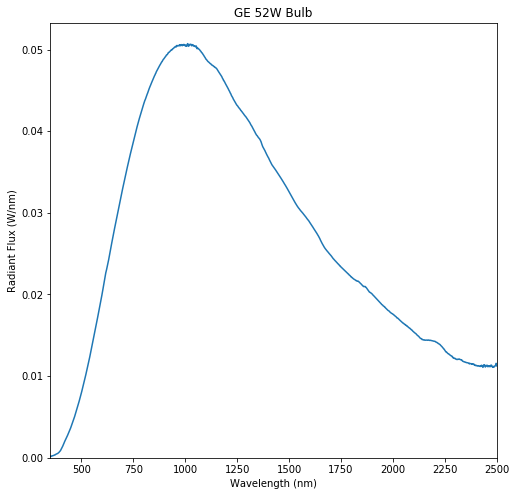

In [95]:
# Read in data
df = pd.read_csv('Incandescent_Lamps_20100311.csv', na_filter=False);
wavelength = df['Wavelength (nm)']
ge_spec_rad = df['GE Wattmiser 52 W frosted']

# Show data
hfig = plt.figure(figsize=(8,8));
hax = plt.axes();
plt.plot(wavelength,ge_spec_rad);
plt.title('GE 52W Bulb');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Radiant Flux (W/nm)');
plt.axis([np.amin(wavelength), np.amax(wavelength), 0, 1.05*np.amax(ge_spec_rad)]);

What we see here is proportional to the power at a given wavelength meaning that the light bulb generates more power at 1000 nm (an invisible wavelength) than it does at 550 nm (green). The area under this curve will then be proportional to the total power radiated by the lightbulb. Here you can also see the spectral radiance covers a wide range of wavelengths looking to extend even beyond 2500 nm. It'd be nice if the group that took this data had taken it to a longer wavelength, but overall I'm not disappointed.

To validate the efficiency numbers we got earlier we'll need to take a look at just the visible range of this graph, which was defined by the sensitivity of the eye.

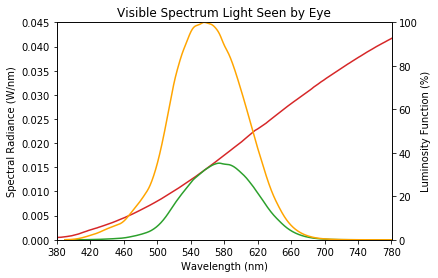

In [96]:
# Plot light bulb spectral radiance
fig, ax1 = plt.subplots()
color = 'tab:red'
h1 = ax1.plot(wavelength,ge_spec_rad,color=color,label='Spectral Radiance')
ax1.set_ylabel('Spectral Radiance (W/nm)')

# Plot luminosity function on second axis
ax2 = ax1.twinx()
h2 = ax2.plot(lam, lum_func*100,color='orange',label='Luminosity Function')
ax2.set_ylabel('Luminosity Function (%)')
ge_spec_rad_vis = np.interp(lam,wavelength,ge_spec_rad)*lum_func;

# Plot resultant luminous flux on first axis
color = 'tab:green';
h3 = ax1.plot(lam,ge_spec_rad_vis,color=color,label='Luminous Flux')

# General plot control
plt.title('Visible Spectrum Light Seen by Eye')
plt.xlim([380,780]);
ax1.set_ylim([0, 0.045]);
ax1.set_xlabel('Wavelength (nm)');
ax1.set_xticks(np.arange(380,780+40,40))
ax2.set_ylim([0, 100]);

You see here how the eye's own spectral response (luminosity function) has an effect on the total amount of light perceived by the eye. By mutiplying the two we get the luminous flux curve, which when integrated will give us the total power seen by the eye.

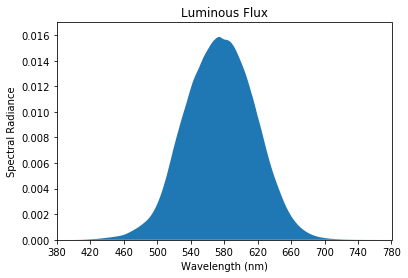

In [97]:
plt.figure()
plt.fill_between(lam, ge_spec_rad_vis);
plt.title('Luminous Flux');
plt.ylabel('Spectral Radiance');
plt.xlabel('Wavelength (nm)');
plt.xlim([380,780])
plt.ylim([0, 0.017])
plt.xticks(np.arange(380,820,40));

In [98]:
calc_visible_radiated_power = np.trapz(ge_spec_rad_vis,lam);
calc_luminous_power = calc_visible_radiated_power * lumen_per_watt; 
print('Data Sheet Luminous Efficacy: {:.2f} lm/W'.format(ge_bulb_luminous_efficacy))
print('Calculated Luminous Efficacy: {:.2f} lm/W'.format(calc_luminous_power/52))
print('Data Sheet Luminous Efficiency: {:.2f} %'.format(100* ge_bulb_luminous_efficiency))
print('Calculated Luminous Efficiency: {:.2f} %'.format(calc_visible_radiated_power/52*100))

Data Sheet Luminous Efficacy: 13.65 lm/W
Calculated Luminous Efficacy: 22.42 lm/W
Data Sheet Luminous Efficiency: 2.00 %
Calculated Luminous Efficiency: 3.28 %


When we calculate the actual efficiencies we see that we are indeed very close to the data sheet efficiencies.

# Colormatching

1. Show cone LSM reponses
2. Show original RGB color matching profiles

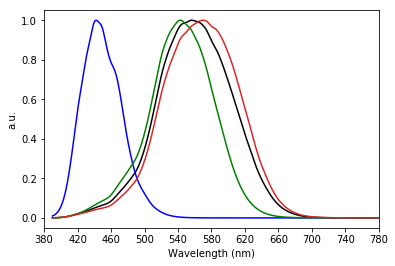

In [125]:
# plt.figure(figsize=(8,8))
lum_func2 = np.interp(lam2,lam,lum_func);
plt.plot(lam2,lum_func2,label='Luminosity Function',color='black')
plt.plot(lam2,s_curve,label='Short',color='blue');
plt.plot(lam2,m_curve,label='Medium',color='green');
plt.plot(lam2,l_curve,label='Long',color='tab:red');
# plt.title('Normalized Cone Response')
plt.xlabel('Wavelength (nm)');
plt.xlim([380, 780]); plt.xticks(np.arange(380,820,40));
plt.ylabel('a.u.');

# References
1. http://jamie-wong.com/post/color/
2. http://www.cvrl.org/
3. https://fluxometer.com/rainbow/#!id=lights/GE%20Incandescent&action=CIE1924Photopic
4. https://www.ngdc.noaa.gov/eog/spectra.html
5. https://www.ngdc.noaa.gov/eog/pubs/sensors-10-03961.pdf
6. https://en.wikipedia.org/wiki/Radiance
1. https://en.wikipedia.org/wiki/Radiative_flux
1. https://en.wikipedia.org/wiki/Intensity_(physics)
7. https://www.grainger.com/product/GE-LIGHTING-46-52-Watts-Incandescent-Lamp-1CWU7
8. https://www.reynoldsonline.com/ASSETS/DOCUMENTS/ITEMS/EN/GELA60A_52WM130V130_Spec.pdf
8. http://python4esac.github.io/fitting/example_blackbody.html
9. https://light-measurement.com/basic-radiometric-quantities/

[2.75200966e+03 8.07812802e-14]


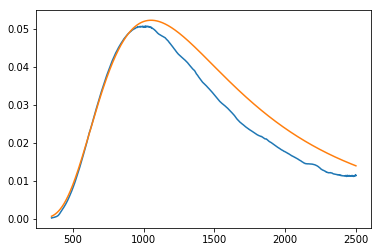

In [294]:
def radiator(lam,T,scale=1):
    from scipy.constants import h,k,c
    lam = lam * 1e-9; # Convert wavelengths to meters
    return scale*2*h*c**2  / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

idx = (wavelength >= 0) & (wavelength <= 1000)
plt.plot(wavelength,lamp)
popt, pcov = optimize.curve_fit(radiator,wavelength[idx],lamp[idx],p0=(2800,1e-9*1e-4))
plt.plot(wavelength,radiator(wavelength, *popt));
print(popt)

The data looks like a pretty good fit, but what does it look like extrapolated?

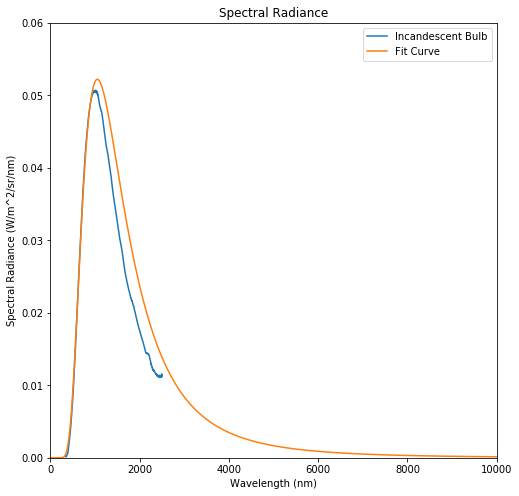

In [286]:
full_spectrum = np.logspace(0,4,1001);
estimated_lamp = radiator(full_spectrum, *popt);
plt.figure(figsize=(8,8));
plt.plot(wavelength,lamp);
plt.plot(full_spectrum,estimated_lamp);
plt.title('Spectral Radiance');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral Radiance (W/m^2/sr/nm)');
plt.legend(['Incandescent Bulb','Fit Curve']);
plt.xlim([0,10000]);
plt.ylim([0, 0.06]);

In [288]:
tt = np.trapz(estimated_lamp,full_spectrum)
print(tt)

83.13146231656462


Sanity check, does this make sense? It seems reasonable that the exponential looking taper at the high end would continue, but without the data we don't know. Let's keep digging.

You can see that the units on the y-axis are $W/m^2/sr/nm$ implying that we've got 3 levels of integration here to get to just a power value. Going back to the Wikipedia Radiance page we have:

$L_{{{\mathrm  {e}},\Omega, \lambda }}={\frac  {\partial ^{2}\Phi _{{\mathrm  {e}}}}{\partial \Omega \,\partial \lambda \,\partial A\cos \theta }}$

and

> When calculating the radiance emitted by a source, A refers to an area on the surface of the source, and Ω to the solid angle into which the light is emitted.

Just for gits and shiggles let's assume that our lightbulb is a GE 60A/52WM-130V which is pretty much your run of the mill lightbulb. It has a diameter of ~60.3 mm and we'll assume it radiates in all directions evenly. It also has an efficiency of 13.65 lumens per watt.

# [Radiant/Spectral Flux](https://en.wikipedia.org/wiki/Radiant_flux)

>In radiometry, radiant flux or radiant power is the radiant energy emitted, reflected, transmitted or received, per unit time, and spectral flux or spectral power is the radiant flux per unit frequency or wavelength, depending on whether the spectrum is taken as a function of frequency or of wavelength.

From [Radiance](https://en.wikipedia.org/wiki/Radiance)<br>
>When calculating the radiance emitted by a source, A refers to an area on the surface of the source, and Ω to the solid angle into which the light is emitted. When calculating radiance received by a detector, A refers to an area on the surface of the detector and Ω to the solid angle subtended by the source as viewed from that detector. When radiance is conserved, as discussed above, the radiance emitted by a source is the same as that received by a detector observing it.

Assumption 1: The lightbulb radiates evenly in all directions meaning we integrate across all 4 Pi sterradians.<br>
Assumption 2: The radiating source area is a sphere encapsulating the lightbulb filament.

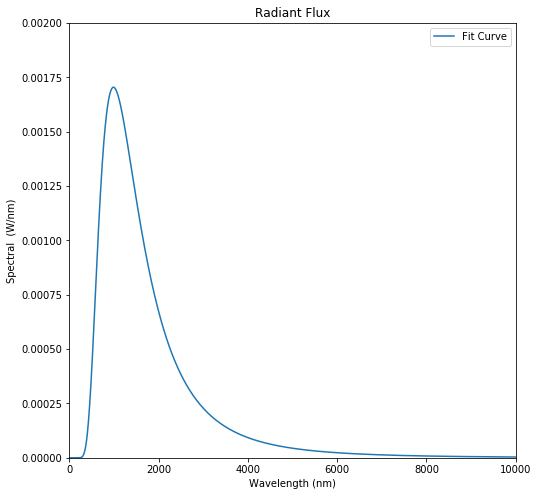

In [97]:
# "Integration" across a sphere
sr_sphere = 4*np.pi;
# Change spectral radiance to spectral flux density
spectral_flux_density = estimated_lamp * sr_sphere;

# Change spectral flux density to spectral_flux
filament_length = 30e-3;
area_sphere = sr_sphere * (filament_length/2)**2;
spectral_flux = spectral_flux_density * area_sphere;

# Plotting
plt.figure(figsize=(8,8));
plt.plot(full_spectrum,spectral_flux);
plt.title('Radiant Flux');
plt.xlabel('Wavelength (nm)');
plt.ylabel('Spectral  (W/nm)');
plt.legend(['Fit Curve']);
plt.axis([0,10000,0,0.002]);

In [98]:
# Integrate spectral flux to get radiant flux
total_radiant_flux = np.trapz(spectral_flux,full_spectrum)
print('Total broadband power that is radiated: {}'.format(total_radiant_flux))

Total broadband power that is radiated: 2.550111631673034


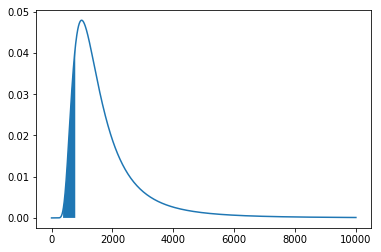

In [99]:
vis_min = 380;
vis_max = 780;
idx = (wavelength >= vis_min) & (wavelength <= vis_max)
plt.plot(full_spectrum,estimated_lamp)

plt.fill_between(wavelength[idx],radiator(wavelength[idx], *popt))
# plt.xlim([300, 1000])

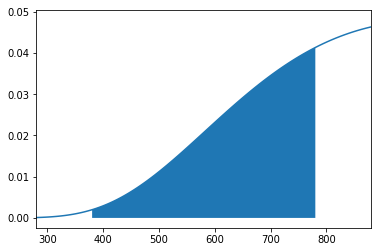

In [100]:

idx = (wavelength >= vis_min) & (wavelength <= vis_max)
plt.plot(full_spectrum,estimated_lamp)

plt.fill_between(wavelength[idx],radiator(wavelength[idx], *popt))
plt.xlim([280, 880]);

In [101]:
vis_idx = (full_spectrum >= vis_min) & (full_spectrum <=vis_max);
vis_spectrum = full_spectrum[vis_idx];
vis_spectral_flux = spectral_flux[vis_idx];
# Integrate to get visible radiant flux
vis_radiant_flux = np.trapz(vis_spectral_flux,vis_spectrum)
print('Total visible power radiated: {}'.format(vis_radiant_flux))


Total visible power radiated: 0.29754174651276066


## [Human Sensitivity & Luminous Flux](https://en.wikipedia.org/wiki/Luminous_flux)

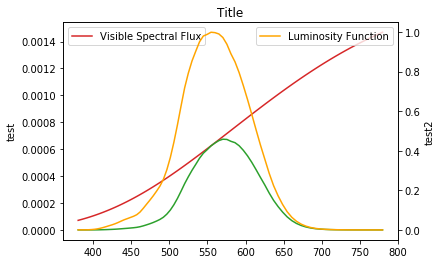

In [102]:
df = pd.read_csv('2deg_luminous_function.csv',names=['wave','amp'])
lum_fun = np.interp(vis_spectrum,df['wave'],df['amp'])
# Convert total spectral flux in visible spectrum to the luminous flux
vis_spectral_lum_flux = lum_fun * vis_spectral_flux;

fig, ax1 = plt.subplots()

color = 'tab:red'
h1 = ax1.plot(vis_spectrum,vis_spectral_flux,color=color,label='Visible Spectral Flux')

ax1.set_ylabel('test')
plt.legend()

ax2 = ax1.twinx()

h2 = ax2.plot(vis_spectrum, lum_fun,color='orange',label='Luminosity Function')
ax2.set_ylabel('test2')

plt.title('Title')
plt.legend()
color = 'tab:green';
h3 = ax1.plot(vis_spectrum,vis_spectral_lum_flux,color=color,label='Luminous Flux')

plt.legend()

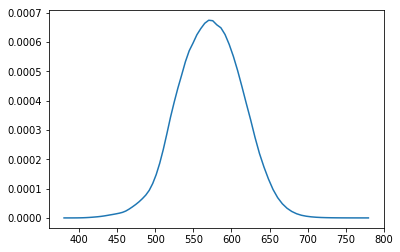

In [103]:
# Plot just the luminous flux from the light bulb
fig, ax1 = plt.subplots()
ax1.plot(vis_spectrum, vis_spectral_lum_flux);

In [104]:
vis_lum_flux = np.trapz(vis_spectral_lum_flux,vis_spectrum)
print('Total power seen by a person: {}'.format(vis_lum_flux))

watt2lumen = 683.002;
human_lum_flux = vis_lum_flux * watt2lumen
print('Total lumens seen by a person: {}'.format(human_lum_flux))

Total power seen by a person: 0.07342038619077842
Total lumens seen by a person: 50.146270609074044


In [106]:
print('Calculated Total Power Efficiency as %: ', 100 * total_radiant_flux / 52)
print('Calculated Human Visible Power Efficiency as %: ', 100 * vis_lum_flux / 52)
print('Expected Lumens per Watt: {0}'.format(710/52))
print('Calculated Lumens per Watt: {0}'.format(human_lum_flux/52))


Calculated Total Power Efficiency as %:  4.90406083014045
Calculated Human Visible Power Efficiency as %:  0.1411930503668816
Expected Lumens per Watt: 13.653846153846153
Calculated Lumens per Watt: 0.9643513578668086


You can see here by the lumen efficiency (LE) that we have overestimated the efficiency of the lightbulb. The quoted LE for the lightbulb is 13.65 lumens/watt; however, we have calculated an LE of 19.56. This error could come from a number of places but likely comes from the mismatch

## Wright-Guild color matching experiments
In the 1920's David Wright and John Guild each performed a series of experiments on human sight which laid the foundation for the specification of the CIE XYZ color space.

# The XYZ color matching functions

Originally, 

http://jcgt.org/published/0002/02/01/paper.pdf


In [14]:
def selector(x, y, z):
        return y * (1 - np.heaviside(x,0.5)) + z * np.heaviside(x,0.5)
    
def x_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([0.362, 1.056, -0.065])
    beta  = np.array([442.0, 599.8, 501.1])
    gamma = np.array([0.0624, 0.0264, 0.0490])
    delta = np.array([0.0374, 0.0323, 0.0382])
    
    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,3):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def y_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([0.821, 0.286])
    beta  = np.array([568.8, 530.9])
    gamma = np.array([0.0213, 0.0613])
    delta = np.array([0.0247, 0.0322])

    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,2):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def z_bar(wavelength):
    # Curve fitting constants from linked paper above
    alpha = np.array([1.217, 0.681])
    beta  = np.array([437.0, 459.0])
    gamma = np.array([0.0845, 0.0385])
    delta = np.array([0.0278, 0.0725])
    
    # Initialize x for summation
#     x = np.zeros(wavelength.shape)
    x = 0
    # Summation
    for nn in range(0,2):
        x = x + alpha[nn] * np.exp(-0.5 * ((wavelength - beta[nn]) * selector(wavelength - beta[nn],gamma[nn],delta[nn])) ** 2)
        
    return x

def cie_std_observer(wavelength):
    return x_bar(wavelength), y_bar(wavelength), z_bar(wavelength)

In [15]:
wv = np.linspace(380,780,101);
xx, yy, zz = cie_std_observer(wv);

rgb2xyz = np.array([[2.768, 1.751, 1.130],[1.000, 4.590, 0.060],[0.000, 0.056, 5.594]])
xyz2rgb = np.linalg.inv(rgb2xyz)

xyz_data = np.array([xx, yy, zz])
rgb_data = np.dot(xyz2rgb, xyz_data)
rr = rgb_data[0,:]
gg = rgb_data[1,:]
bb = rgb_data[2,:]

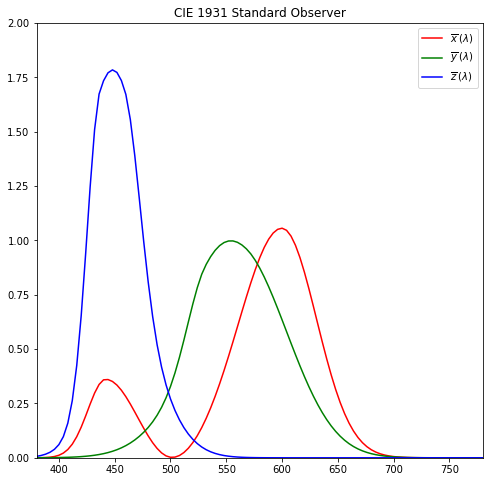

In [16]:
# %matplotlib notebook; %matplotlib notebook;
# %matplotlib inline
plt.figure(figsize=(8,8))
plt.plot(wv,xx,'r',label='$\overline{x}\;(\lambda)$')
plt.plot(wv,yy,'g',label='$\overline{y}\;(\lambda)$')
plt.plot(wv,zz,'b',label='$\overline{z}\;(\lambda)$')
plt.axis([np.amin(wv), np.amax(wv), 0.0, 2.0]);
plt.title('CIE 1931 Standard Observer')
plt.legend();

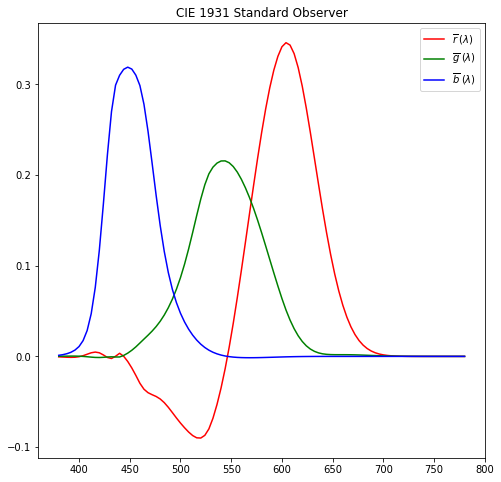

In [17]:
# %matplotlib notebook; %matplotlib notebook;
# %matplotlib inline
plt.figure(figsize=(8,8))
plt.plot(wv,rr,'r',label='$\overline{r}\;(\lambda)$')
plt.plot(wv,gg,'g',label='$\overline{g}\;(\lambda)$')
plt.plot(wv,bb,'b',label='$\overline{b}\;(\lambda)$')
# plt.axis([np.amin(wv), np.amax(wv), 0.0, 2.0]);
plt.title('CIE 1931 Standard Observer')
plt.legend();

In [18]:
r = np.linspace(0,1,101)/3
g = np.linspace(0,1,101)/3
b = np.linspace(0,1,101)/3


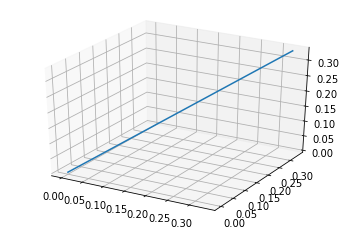

In [19]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(r,g,b)

1. http://www.stonesc.com/pubs/Stone%20CGA%2007-2005.pdf